# Preprocesamiento y extracción de características
Los transformadores generalmente se combinan con clasificadores, regresores u otros estimadores para construir un estimador compuesto. La herramienta más común es una tubería. La tubería a menudo se usa en combinación con FeatureUnion, que concatena la salida de los transformadores en un espacio compuesto de características. TransformedTargetRegressor trata de transformar el objetivo (es decir, log-transform y). En contraste, las tuberías solo transforman los datos observados (X).

# Pipeline: estimadores de encadenamiento

El pipeline se puede utilizar para encadenar múltiples estimadores en uno. Esto es útil ya que a menudo hay una secuencia fija de pasos en el procesamiento de los datos, por ejemplo, selección de características, normalización y clasificación. La tubería sirve para múltiples propósitos aquí:

Conveniencia y encapsulación
    Solo tiene que llamar al ajuste y predecir una vez en sus datos para ajustar una secuencia completa de estimadores.
Selección conjunta de parámetros
    Puede buscar en la cuadrícula los parámetros de todos los estimadores en la tubería a la vez.
La seguridad
    Las tuberías ayudan a evitar la filtración de estadísticas de sus datos de prueba en el modelo entrenado en validación cruzada, al garantizar que se usen las mismas muestras para entrenar los transformadores y predictores.

Todos los estimadores en una tubería, excepto el último, deben ser transformadores (es decir, deben tener un método de transformación). El último estimador puede ser de cualquier tipo (transformador, clasificador, etc.).



Los pipelines se crean utilizando una lista de pares (clave, valor), donde la clave es una cadena que contiene el nombre que desea dar a este paso y el valor es un objeto estimador:

# EJEMPLO:


Este ejemplo construye una tubería que hace una reducción de dimensionalidad seguida de una predicción con un clasificador de vectores de soporte. Demuestra el uso de GridSearchCV y Pipeline para optimizar diferentes clases de estimadores en una sola ejecución de CV: las reducciones de dimensionalidad de PCA y NMF sin supervisión se comparan con la selección de características univariadas durante la búsqueda de cuadrícula.

Además, se puede crear una instancia de Pipeline con el argumento de memoria para memorizar los transformadores dentro de la tubería, evitando volver a colocar los mismos transformadores una y otra vez.

Tenga en cuenta que el uso de la memoria para habilitar el almacenamiento en caché se vuelve interesante cuando la instalación de un transformador es costosa



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

pipe=Pipeline([('reduce_dim','passthrough'),('classify',LinearSVC(dual=False,max_iter=10000))])

N_FEATURES_OPTIONS=[2,4,8]
C_OPTIONS=[1,10,100,1000]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]

reducer_labels=['PCA','NMF','KBest(chi2)']

grid=GridSearchCV(pipe,cv=5,n_jobs=1,param_grid=param_grid,iid=False)

digits=load_digits()

grid.fit(digits.data,digits.target)






GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=False,
                                                  fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=10000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid=False, n_j...
       

(4, 3, 3)


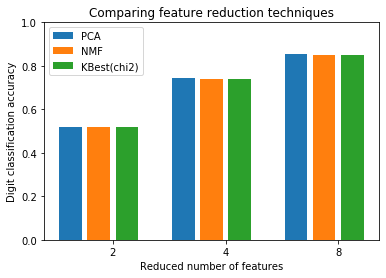

In [26]:
mean_scores=np.array(grid.cv_results_['mean_test_score'])
mean_scores=mean_scores.reshape(len(C_OPTIONS),3,len(N_FEATURES_OPTIONS))
print(mean_scores.shape)

mean_scores=mean_scores.max(axis=0)
bar_offsets=(np.arange(len(N_FEATURES_OPTIONS))*(len(reducer_labels)+1))

plt.figure()
for i,(label,reducer_scores) in enumerate(zip(reducer_labels,mean_scores)):
    plt.bar(bar_offsets+i,reducer_scores,label=label)

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()



EJEMPLO 2:

En muchos ejemplos del mundo real, hay muchas formas de extraer características de un conjunto de datos. A menudo es beneficioso combinar varios métodos para obtener un buen rendimiento. Este ejemplo muestra cómo usar FeatureUnion para combinar características obtenidas por PCA y selección univariada.

La combinación de características que utilizan este transformador tiene la ventaja de que permite la validación cruzada y las búsquedas en la red durante todo el proceso.

La combinación utilizada en este ejemplo no es particularmente útil en este conjunto de datos y solo se utiliza para ilustrar el uso de FeatureUnion.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
print(__doc__)


RANDOM_STATE = 42
FIG_SIZE = (10, 7)


features, target = load_wine(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)


unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)


std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)


Automatically created module for IPython interactive environment


In [5]:
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))



Prediction accuracy for the normal test dataset with PCA
81.48%


Prediction accuracy for the standardized test dataset with PCA
98.15%




PC 1 without scaling:
 [ 1.76342917e-03 -8.35544737e-04  1.54623496e-04 -5.31136096e-03
  2.01663336e-02  1.02440667e-03  1.53155502e-03 -1.11663562e-04
  6.31071580e-04  2.32645551e-03  1.53606718e-04  7.43176482e-04
  9.99775716e-01]

PC 1 with scaling:
 [ 0.13443023 -0.25680248 -0.0113463  -0.23405337  0.15840049  0.39194918
  0.41607649 -0.27871336  0.33129255 -0.11383282  0.29726413  0.38054255
  0.27507157]

No estandarizada:
 [0.99768115 0.00213287]

Estandarizada:
 [0.36196226 0.18763862]


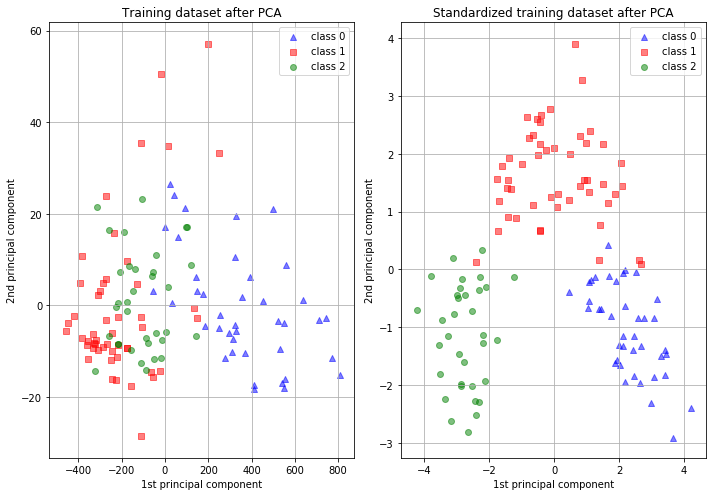

In [13]:
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

print('\nPC 1 without scaling:\n', pca.components_[0])
print('\nPC 1 with scaling:\n', pca_std.components_[0])



print('\nNo estandarizada:\n', pca.explained_variance_ratio_)
print('\nEstandarizada:\n', pca_std.explained_variance_ratio_)


X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)


for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train_transformed[y_train == l, 0],
                X_train_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

# Descomposición: PCA

Cuando derivamos PCA, asumimos que nuestros datos están centrados, lo que significa que tienen una media 0. Esta suposición no es necesariamente correcta para PCA, y habríamos llegado al mismo resultado, pero restar la media de los datos puede evitar dificultades numéricas. Primero, restamos la media de los datos y la enviamos a cero para evitar problemas numéricos. En segundo lugar, dividimos por la desviación estándar para liberar la unidad de datos. Tercero, calculamos los valores propios y los vectores propios de la matriz de covarianza de datos. Y, por último, podemos proyectar cualquier punto de datos en el subespacio principal que abarca los vectores propios que pertenecen a los valores propios más grandes.

# Importancia del escalado de características

El escalado de características a través de la estandarización (o la normalización de la puntuación Z) puede ser un paso importante de preprocesamiento para muchos algoritmos de aprendizaje automático. La estandarización implica reescalar las características de modo que tengan las propiedades de una distribución normal estándar con una media de cero y una desviación estándar de uno.

Si bien muchos algoritmos (como SVM, vecinos más cercanos a K y regresión logística) requieren que las características se normalicen, intuitivamente podemos pensar en el Análisis de componentes principales (PCA) como un excelente ejemplo de cuándo la normalización es importante. En PCA estamos interesados ​​en los componentes que maximizan la varianza. Si un componente (por ejemplo, la altura humana) varía menos que otro (por ejemplo, el peso) debido a sus respectivas escalas (metros frente a kilos), la PCA podría determinar que la dirección de la varianza máxima se corresponde más estrechamente con el eje de 'peso', si esas características No están escalados. Como un cambio en la altura de un metro puede considerarse mucho más importante que el cambio en el peso de un kilogramo, esto es claramente incorrecto.

Para ilustrar esto, PCA se realiza comparando el uso de datos con StandardScaler aplicado, a datos sin escala. Los resultados se visualizan y se observa una clara diferencia. Se puede ver el primer componente principal en el conjunto sin escala. Se puede ver que la característica # 13 domina la dirección, siendo un total de dos órdenes de magnitud por encima de las otras características. Esto se contrasta al observar el componente principal para la versión escalada de los datos. En la versión escalada, los órdenes de magnitud son aproximadamente los mismos en todas las características.

El conjunto de datos utilizado es el Wine Dataset disponible en UCI. Este conjunto de datos tiene características continuas que son heterogéneas en escala debido a las diferentes propiedades que miden (es decir, contenido de alcohol y ácido málico).

Los datos transformados se usan luego para entrenar a un ingenuo clasificador de Bayes, y se observa una clara diferencia en las precisiones de predicción en el que el conjunto de datos que se escala antes de PCA supera ampliamente la versión sin escala.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
print(__doc__)

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

RANDOM_STATE = 42
FIG_SIZE = (10, 7)


features, target = load_wine(return_X_y=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)

print(X_train.shape)
import pandas as pd
import seaborn as sns
a = pd.DataFrame(features)     
sns.pairplot(a)

Automatically created module for IPython interactive environment
(124, 13)


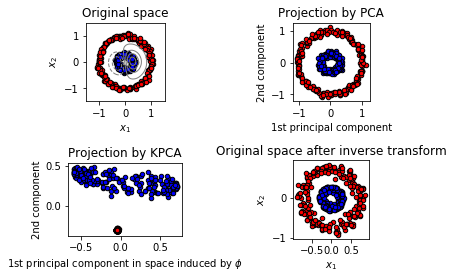

In [10]:

# Authors: Mathieu Blondel
#          Andreas Mueller
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()